You are given an excerpt of the log data from the [Swisslos](https://www.swisslos.ch) Jass servers collected between October 2017 and April 2018. In the Swiss card game [Jass](https://en.wikipedia.org/wiki/Jass), at the beginning of each round just after the cards have been dealt, the current player announces her choice of the trump mode from the options: diamonds, hearts, spades, club, obe-abe, une-ufe and push (only available when forehand). Use this information from human players to train a machine learning classifier in trump mode prediction.

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from pathlib import Path

# Import & Prepare Data

In [2]:
path_to_data = Path('jass_data')

In [3]:
# Import only a fraction of data for efficient development and testing
# data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None, nrows=6000)

# Import all data in the final run
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


In [4]:
# Display number of rows and columns
data.shape

(359825, 39)

## Rename Columns for better Interpretability

In [5]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
print(data.head())

   DA  DK  DQ  DJ  D10  D9  D8  D7  D6  HA  ...  CQ  CJ  C10  C9  C8  C7  C6  \
0   0   0   0   1    1   0   1   1   0   0  ...   1   0    0   0   1   0   0   
1   0   0   0   0    0   0   0   0   1   1  ...   0   1    0   0   0   1   0   
2   1   0   0   1    0   0   0   0   0   0  ...   1   0    0   0   0   1   1   
3   0   0   0   0    0   0   0   0   0   1  ...   0   0    1   1   0   0   0   
4   0   1   0   0    0   0   0   0   1   1  ...   0   1    0   0   0   0   0   

   FH   user  trump  
0   0  53248      6  
1   0   4613      5  
2   0  68780      6  
3   0  24555      5  
4   1   8392      4  

[5 rows x 39 columns]


## Remove User Information

Later on you may want to keep this information. For now, we remove it just to avoid mistakes.

In [6]:
# data.drop('user', axis='columns', inplace=True)

In [7]:
data.head(10)

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,53076,5
6,1,1,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,41630,6
7,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,1,0,78376,1
8,0,1,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,1,55544,5
9,0,1,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


## Adjust Datatypes

In [8]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.dtypes

## Rename Target Category Values for better Interpretability

In [9]:
# Backward compatibility: Value 10 for PUSH was used in an older version by Swisslos

data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})
print(data.head())

      DA     DK     DQ     DJ    D10     D9     D8     D7     D6     HA  ...  \
0  False  False  False   True   True  False   True   True  False  False  ...   
1  False  False  False  False  False  False  False  False   True   True  ...   
2   True  False  False   True  False  False  False  False  False  False  ...   
3  False  False  False  False  False  False  False  False  False   True  ...   
4  False   True  False  False  False  False  False  False   True   True  ...   

      CQ     CJ    C10     C9     C8     C7     C6     FH   user    trump  
0   True  False  False  False   True  False  False  False  53248     PUSH  
1  False   True  False  False  False   True  False  False   4613  UNE_UFE  
2   True  False  False  False  False   True   True  False  68780     PUSH  
3  False  False   True   True  False  False  False  False  24555  UNE_UFE  
4  False   True  False  False  False  False  False   True   8392  OBE_ABE  

[5 rows x 39 columns]


In [10]:
filtered_df = data[(data['FH'] == True) & (data['trump'] == "PUSH")]


In [11]:
count = ((data['FH'] == True) & (data['trump'] == "PUSH")).sum()
print("Count of rows where FH is True and trump is PUSH:", count)


Count of rows where FH is True and trump is PUSH: 0


# Data Quality Assessment

### Exercise: Sanity Check

Each row in the data now corresponds to one hand of a player plus her trump mode selection. Verify that each hand contains exactly 9 cards.

In [12]:
data['cards_count'] = data[cards].sum(axis=1)
valid_hands = data['cards_count'] == 9  

if valid_hands.all():
    print("All hands contain exactly 9 cards.")
else:
    print("There are hands that do not contain exactly 9 cards.")
    print(data[~valid_hands][['card_count'] + cards])

All hands contain exactly 9 cards.


### Exercise: Statistical Fingerprint

Swisslos claims to distribute cards randomly.
* Verify that all card features roughly have the same mean and standard deviation.
* Over a **large number of rounds**, we would expect similar percentages for diamonds, hearts, spades and clubs as selected Trump. Verify this claim.

Hint: you may want to use [np.allclose(...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) in combination with an assert statement for automated checking.

#### A note on randomness - not part of exercises: 

The above test is obviously a very poor guarantee of randomness. However, we perform such tests from the viewpoint of data quality rather than fairness. If you want to challenge the random number generator of Swisslos, use the NIST or Diehard test suite for randomness. Read more about random number tests <a href='https://gerhardt.ch/random.php'>here</a>. We have not done this ourselves and keep believing that the provider of Swiss lottery use a reasonable source of randomness even for online games :-)

In [13]:
# Calculate mean and standard deviation for each card
means = data[cards].mean()
std_devs = data[cards].std()


In [14]:
np.allclose(means, means.mean())

False

In [15]:
np.allclose(std_devs, std_devs.mean())

False

In [16]:
data.trump.value_counts()

trump
PUSH        137554
UNE_UFE      44653
SPADES       40115
CLUBS        39756
OBE_ABE      35829
HEARTS       31087
DIAMONDS     30831
Name: count, dtype: int64

Can you explain ...
* the difference between Une-Ufe and Obe-Abe ?
* the difference between {spades, clubs} and {hearts, diamonds}

The fact that the values of the response are not distributed evenly has implications on the train-test split in the next section.

# Modelling and Prediction

### Train-Test Split

Split the available data into a training and a test set and put the test set aside for the final model evaluation. Use 20% of the data for testing, and set the random_state to 42 for reproducability. Since we found out that the classes are not distributed evenly, you need to stratify. Also, be aware that train_test_split() shuffles the data by default, which is what we want here (but not always, e.g. not in case of time series).

Your result should be the four variables *X_train, X_test, y_train, y_test*.

In [17]:
from sklearn.model_selection import train_test_split

feature_columns = cards + forehand
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

## Baseline with a Logistic Regression Classifier

We create a (linear) logistic regression classifier and evaluate it with cross validation.

In [18]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# 
# classifier = LogisticRegression()
# 
# # Note that we do not use the test set here !
# result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)
# 
# print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

In [19]:
y_train.head()

207217    HEARTS
18232       PUSH
226960    HEARTS
128112      PUSH
126859      PUSH
Name: trump, dtype: category
Categories (7, object): ['DIAMONDS', 'HEARTS', 'SPADES', 'CLUBS', 'OBE_ABE', 'UNE_UFE', 'PUSH']

### Exercise: Stochastic Gradient Descent

Machine learning classifiers internally use an optimization algorithm. Stochastic gradient descent is a stochastic 
approximation that generally is more efficient but with a slightly lower convergence rate. Change the code in the previous cell to a logistic regression with stochastic gradient descent. Use [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) with parameters *loss='log'* and *penalty='None'*

In [20]:
# from sklearn.linear_model import SGDClassifier
# 
# classifier = SGDClassifier(loss='log_loss', penalty=None)
# result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)
# 
# print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

## Learning Curves

Learning curves are an important diagnostic instrument in machine learning. A cross-validation generator splits the whole dataset k times into training and test data. Subsets of the training set with increasing sizes will be used to train the estimator and a score for each training subset size on the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

As a rule of thumb, a gap between the training and validation curves indicates that using more data would improve accuracy.

In [21]:
# from sklearn.model_selection import learning_curve
# 
# train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(loss='log_loss', penalty=None), 
#                                                          X_train, y_train, n_jobs=-1,
#                                                          train_sizes=np.linspace(0.1, 1.0, 50), cv=10,
#                                                          exploit_incremental_learning=True, verbose=10)

In [22]:
# plot_data = pd.DataFrame({'train':train_scores.mean(axis=1), 'validation':valid_scores.mean(axis=1)}, index=train_sizes)
# f, ax = plt.subplots(figsize=(14, 6))
# ax.set_xlabel('#samples')
# ax.set_ylabel('Accuracy')
# ax.set_title('SGD')
# plot_data.plot(ax=ax)
# plt.grid()

### Exercise: Create a Random Forest Classifier

Now create a random forest classifier and evaluate it with cross validation.

In [23]:
# from sklearn.ensemble import RandomForestClassifier
# 
# classifier = RandomForestClassifier()
# result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)
# 
# print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

### Exercise: List and Plot Feature Importances

Tree classsifiers (such as decision trees and random forests) can conveniently list feature importances. They use feature values to split the training set, whereas more important features are used higher in the tree(s). Use the *feature_importances_* attribute of a trained RandomForestClassifier to obtain a sorted list of the most important features. Plot feature importances in a bar chart.

In [24]:
# # Train classifier
# classifier.fit(X_train, y_train)

In [25]:
# # Get feature importances
# feature_importances = classifier.feature_importances_

In [26]:
# indices = np.argsort(feature_importances)[::-1]
# sorted_features = np.array(X_train.columns)[indices]
# sorted_importances = feature_importances[indices]

In [27]:
# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_features)), sorted_importances, align="center")
# plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.title("Feature Importances in Random Forest Classifier")
# plt.tight_layout()
# plt.show()

## Grid Search over multiple Classifiers and Hyperparameters

In [28]:
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# 
# # Classifier names
# names = [
#     "Logistic Regression",
#     "Random Forest",
#     "SVC",
#     "KNeighborsClassifier",
#     "GradientBoostingClassifier",
#     "MLPClassifier"
#     
# ]
# 
# # Classifiers
# classifiers = [
#     LogisticRegression(solver='lbfgs'), # set these to avoid a FutureWarning with scikit-lean < 0.22
#     RandomForestClassifier(n_estimators=200),
#     SVC(),
#     KNeighborsClassifier(),
#     GradientBoostingClassifier(),
#     MLPClassifier(max_iter=2000,)
# ]
# 
# # Hyperparameter grid to search per classifier
# parameters = [
#     {'C': [0.5, 1.0, 2.0], 'max_iter': [500, 1000]},
#     {'max_depth': [5, 10]},
#     {'kernel': ['rbf', 'poly', 'sigmoid']},
#     {'n_neighbors': [5, 10], 'weights': ['uniform', 'distance']},
#     {'loss': ['log_loss', 'exponential'], 'learning_rate': [1e-3, 1e-2]},
#     {'hidden_layer_sizes': [64, 128, 256], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']},
# ]
# 
# list(zip(names, parameters))

In [29]:
# from sklearn.model_selection import GridSearchCV
# 
# results = []
# 
# for name, classifier, params in zip(names, classifiers, parameters):
#     print("Grid search for {}".format(name))
#     gs = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
#     gs.fit(X_train, y_train)
#     print("Best accuracy score found: {:.3f}\n".format(gs.best_score_))
#     results.append([name, gs.best_score_, gs.best_estimator_])
# 
# results

Comment: If *refit=True* (the default), the best estimator is made available at the *best_estimator_* attribute of gs and permits using *.predict()* directly on this GridSearchCV instance. Note, however, that the above code runs grid search separately for each classifier, and so gs now only contains the last estimator of the list, which may or may not be the best one. So don't use gs to predict blindly.

### Exercise: Extend Grid Search by adding other Classifiers and Hyperparameters

You may want to experiment with a [nearest neighbors classifier](http://scikit-learn.org/stable/modules/neighbors.html) or a [support vector machine](http://scikit-learn.org/stable/modules/svm.html) or a [neural network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) or ...

### Exercise: Add interactions to Logistic Regression

A linear classifier such as logistic regression cannot model dependencies between features (things like "if your hand has both heart jack and heart nine, then choose heart as trump mode"). But features like these called *interactions* can be added manually.

In [30]:
# # First, get the score without interactions
# clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
# result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
# print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

For each of the four colors, add one interaction term for the combination jack and nine.

In [31]:
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CJ,C10,C9,C8,C7,C6,FH,user,trump,cards_count
0,False,False,False,True,True,False,True,True,False,False,...,False,False,False,True,False,False,False,53248,PUSH,9
1,False,False,False,False,False,False,False,False,True,True,...,True,False,False,False,True,False,False,4613,UNE_UFE,9
2,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,68780,PUSH,9
3,False,False,False,False,False,False,False,False,False,True,...,False,True,True,False,False,False,False,24555,UNE_UFE,9
4,False,True,False,False,False,False,False,False,True,True,...,True,False,False,False,False,False,True,8392,OBE_ABE,9


In [32]:
def count_colors(data):
    colors = {}
    for color in 'DHSC':
        # Count all cards of the given suit (e.g., all Diamonds, Hearts, etc.)
        colors[color] = data[[f'{color}{rank}' for rank in ['A', 'K', 'Q', 'J', '10', '9', '8', '7', '6']]].sum(axis=1)
    return colors

In [33]:
# Initialize lists to store feature names
feature_columns = []
specified_features = []

# Feature creation loop
for color in 'DHSC':
    # Jack and nine combination
    new_col = f'{color}_J9'
    data[new_col] = data[f'{color}J'] & data[f'{color}9']
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # A K Q combination
    new_col = f'{color}_AKQ'
    data[new_col] = data[f'{color}A'] & data[f'{color}K'] & data[f'{color}Q']
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # 6 7 8 combination
    new_col = f'{color}_678'
    data[new_col] = data[f'{color}6'] & data[f'{color}7'] & data[f'{color}8']
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # Jack and nine combination with 4 more cards
    new_col = f'{color}_J_and_4_more'
    has_jack = data[f'{color}J']
    color_count = count_colors(data)[color]
    data[new_col] = has_jack & (color_count >= 5)
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # 9, A, and at least 3 other cards in the same suit
    new_col = f'{color}_9A_and_3_more'
    has_nine = data[f'{color}9']
    has_ace = data[f'{color}A']
    data[new_col] = has_nine & has_ace & (color_count >= 5)
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # Jack, 9, and Ace in the same suit
    new_col = f'{color}_J9A'
    has_jack = data[f'{color}J']
    has_nine = data[f'{color}9']
    has_ace = data[f'{color}A']
    data[new_col] = has_jack & has_nine & has_ace
    feature_columns.append(new_col)
    specified_features.append(new_col)
    
    # Jack, 9, and at least one other card in suit, plus two Aces in other suits
    new_col = f'{color}_J9_plus_card_and_2_other_aces'
    other_ranks = ['A', 'K', 'Q', '10', '8', '7', '6']
    other_cards_in_suit = data[[f'{color}{rank}' for rank in other_ranks]].any(axis=1)
    other_colors = [c for c in 'DHSC' if c != color]
    aces_in_other_suits = data[[f'{c}A' for c in other_colors]].sum(axis=1)
    has_two_aces_in_other_suits = aces_in_other_suits >= 2
    data[new_col] = has_jack & has_nine & other_cards_in_suit & has_two_aces_in_other_suits
    feature_columns.append(new_col)
    specified_features.append(new_col)

# Create a new column that is True if any of the specified features is True
data['any_specified_feature_true'] = data[specified_features].any(axis=1)



In [35]:
data.head(10)

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,S_J9A,S_J9_plus_card_and_2_other_aces,C_J9,C_AKQ,C_678,C_J_and_4_more,C_9A_and_3_more,C_J9A,C_J9_plus_card_and_2_other_aces,any_specified_feature_true
0,False,False,False,True,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
5,False,False,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
6,True,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
8,False,True,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9,False,True,False,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


We must recreate training and test sets with the new features

And check  if the additional columns improve the score

In [36]:
# clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
# result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
# print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

# Pytorch 

### Exercise: Better Accuracy with less Data ?

At the beginning we removed the user ID from our data set. Use this information to develop a heuristic that seggregates between *good* and *bad* players. Can you improve accuracy by using only the data from *good* players?

In [37]:
# Count unique user IDs
num_unique_users = data['user'].nunique()
print("Number of unique users:", num_unique_users)

Number of unique users: 3491


In [38]:
# Count occurrences of each user ID
user_counts = data['user'].value_counts()
print(user_counts)

user
0        94455
4035      1387
19345     1332
56019     1329
331       1091
         ...  
63707        1
27716        1
70588        1
18986        1
7724         1
Name: count, Length: 3491, dtype: int64


In [39]:
def check_bad_decision(row):
    bad_decision = 0
    # Check if player has any special feature
    for color in 'DHSC':
        # Rule for J9 and J_and_4_more: Trump should match the suit
        if row[f'{color}_J9'] and row['trump'] != color:
            bad_decision += 1
            
        if row[f'{color}_J_and_4_more'] and row['trump'] != color:
            bad_decision += 1

        # Rule for AKQ: Trump can be the same suit or OBE_ABE
        if row[f'{color}_AKQ'] and row['trump'] not in [color, 'OBE_ABE']:
            bad_decision += 1
            
        if row[f'{color}_J9_plus_card_and_2_other_aces'] and row['trump'] != color:
            bad_decision += 1
            
        if row[f'{color}_9A_and_3_more'] and row['trump'] != color:
            bad_decision += 1
            
        if row[f'{color}_J9A'] and row['trump'] != color:
            bad_decision += 1

    # Rule for 678: Trump should be UNE_UFE
    if (row['D_678'] or row['H_678'] or row['S_678'] or row['C_678']) and row['trump'] != 'UNE_UFE':
        bad_decision += 1

    # Return 1 if it's a bad decision (incorrect trump choice) for this round, else 0
    return bad_decision > 0

In [40]:
# Apply the bad decision function to each row
data['bad_decision'] = data.apply(check_bad_decision, axis=1)

In [41]:
# Define the threshold for bad player categorization (25% of rounds with special features)
bad_decision_threshold = 0.30

# Count the total number of bad decisions per user
bad_decision_counts = data.groupby('user')['bad_decision'].sum()

# Count the number of rounds with special features per user (rounds where `bad_decision` is evaluated)
special_feature_rounds = data.groupby('user')['bad_decision'].count()

# Calculate the percentage of bad decisions for each user
bad_decision_percentage = (bad_decision_counts / special_feature_rounds).fillna(0)

# Label users as bad if their percentage of bad decisions exceeds the threshold
user_labels = (bad_decision_percentage > bad_decision_threshold).astype(int)  # 1 for bad, 0 for good
user_labels = user_labels.rename("bad_player")

In [42]:
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,S_J9_plus_card_and_2_other_aces,C_J9,C_AKQ,C_678,C_J_and_4_more,C_9A_and_3_more,C_J9A,C_J9_plus_card_and_2_other_aces,any_specified_feature_true,bad_decision
0,False,False,False,True,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False


In [43]:
# Count the number of unique good and bad players
bad_player_counts = user_labels.value_counts()
print(bad_player_counts)

bad_player
0    2181
1    1310
Name: count, dtype: int64


In [44]:
user_labels

user
0        0
1        0
199      1
331      0
345      0
        ..
84453    1
85114    0
85653    1
85654    0
85907    1
Name: bad_player, Length: 3491, dtype: int64

In [45]:
# Filter to keep only good users (where 'bad_player' == 0)
good_users = user_labels[user_labels == 0].index  # Extract user IDs where 'bad_player' is 0


filtered_data = data[data['user'].isin(good_users)]


# Drop the 'bad_player' column if it exists, as we only want the data without bad user information
filtered_data = filtered_data.drop(columns=['bad_player', 'bad_decision', 'user', 'cards_count'], errors='ignore')


print(filtered_data.columns)

Index(['DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6', 'HA', 'HK', 'HQ',
       'HJ', 'H10', 'H9', 'H8', 'H7', 'H6', 'SA', 'SK', 'SQ', 'SJ', 'S10',
       'S9', 'S8', 'S7', 'S6', 'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7',
       'C6', 'FH', 'trump', 'D_J9', 'D_AKQ', 'D_678', 'D_J_and_4_more',
       'D_9A_and_3_more', 'D_J9A', 'D_J9_plus_card_and_2_other_aces', 'H_J9',
       'H_AKQ', 'H_678', 'H_J_and_4_more', 'H_9A_and_3_more', 'H_J9A',
       'H_J9_plus_card_and_2_other_aces', 'S_J9', 'S_AKQ', 'S_678',
       'S_J_and_4_more', 'S_9A_and_3_more', 'S_J9A',
       'S_J9_plus_card_and_2_other_aces', 'C_J9', 'C_AKQ', 'C_678',
       'C_J_and_4_more', 'C_9A_and_3_more', 'C_J9A',
       'C_J9_plus_card_and_2_other_aces', 'any_specified_feature_true'],
      dtype='object')


In [46]:
feature_columns = filtered_data.drop(columns=['trump'])

In [47]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    feature_columns, filtered_data['trump'], test_size=0.2, stratify=filtered_data['trump'], random_state=42
)


print("X_train shape:", X_train.shape)
print("y_train distribution:\n", y_train.value_counts())

X_train shape: (234000, 66)
y_train distribution:
 trump
PUSH        89202
UNE_UFE     29385
SPADES      25959
CLUBS       25546
OBE_ABE     23743
HEARTS      20249
DIAMONDS    19916
Name: count, dtype: int64


In [50]:
print(X_train.values)

[[False  True  True ... False False False]
 [False False False ... False False False]
 [False  True False ... False False False]
 ...
 [False  True  True ... False False  True]
 [ True False False ... False False False]
 [ True  True  True ... False False  True]]


### Exercise: The final Score

Use the best setting you could find, train the classifier on all training data and evaluate on the yet unseen test data.

In [1074]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [1065]:
# Encode the 'trump' target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
push_label_encoded = label_encoder.transform(["PUSH"])[0]


# Convert encoded targets to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


# Define Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [1104]:
# Define the neural network model
class TrumpPredictorNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(TrumpPredictorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_size)
        # self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(0.01)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [1105]:
# Initialize model, loss function, and optimizer with updated input_size

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

input_size = X_train.shape[1]  # Confirm this includes all features (66 in total)
output_size = len(set(y_train))  # Number of unique classes in 'trump'
model = TrumpPredictorNN(input_size, output_size)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [1106]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0  # Initialize total loss for validation
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # Accumulate the loss
            total_loss += loss.item()
    # Calculate average validation loss
    average_loss = total_loss / len(test_loader)
    return average_loss


In [1107]:
# Training function

training_losses = []
validation_losses = []
num_epochs = 25

# Training function with average loss calculation and validation
def train_model(model, train_loader, test_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0  # Initialize total training loss
        for X_batch, y_batch in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(X_batch)
            # Compute loss
            loss = criterion(outputs, y_batch)
            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()
            # Accumulate training loss
            total_train_loss += loss.item()
        # Calculate average training loss
        average_train_loss = total_train_loss / len(train_loader)
        
        # Compute validation loss
        val_loss = evaluate_model(model, test_loader)
        
        # After calculating average losses
        training_losses.append(average_train_loss)
        validation_losses.append(val_loss)
        
        # Print losses
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


In [1109]:
# Training the model
train_model(model, train_loader, test_loader, num_epochs)

Epoch 1/25, Training Loss: 1.1530, Validation Loss: 0.8507
Epoch 2/25, Training Loss: 0.9385, Validation Loss: 0.8112
Epoch 3/25, Training Loss: 0.8979, Validation Loss: 0.7956
Epoch 4/25, Training Loss: 0.8805, Validation Loss: 0.7871
Epoch 5/25, Training Loss: 0.8696, Validation Loss: 0.7808
Epoch 6/25, Training Loss: 0.8597, Validation Loss: 0.7797
Epoch 7/25, Training Loss: 0.8554, Validation Loss: 0.7759
Epoch 8/25, Training Loss: 0.8506, Validation Loss: 0.7737
Epoch 9/25, Training Loss: 0.8475, Validation Loss: 0.7751
Epoch 10/25, Training Loss: 0.8443, Validation Loss: 0.7726
Epoch 11/25, Training Loss: 0.8423, Validation Loss: 0.7718
Epoch 12/25, Training Loss: 0.8412, Validation Loss: 0.7728
Epoch 13/25, Training Loss: 0.8383, Validation Loss: 0.7691
Epoch 14/25, Training Loss: 0.8366, Validation Loss: 0.7704
Epoch 15/25, Training Loss: 0.8360, Validation Loss: 0.7683
Epoch 16/25, Training Loss: 0.8343, Validation Loss: 0.7657
Epoch 17/25, Training Loss: 0.8319, Validation Lo

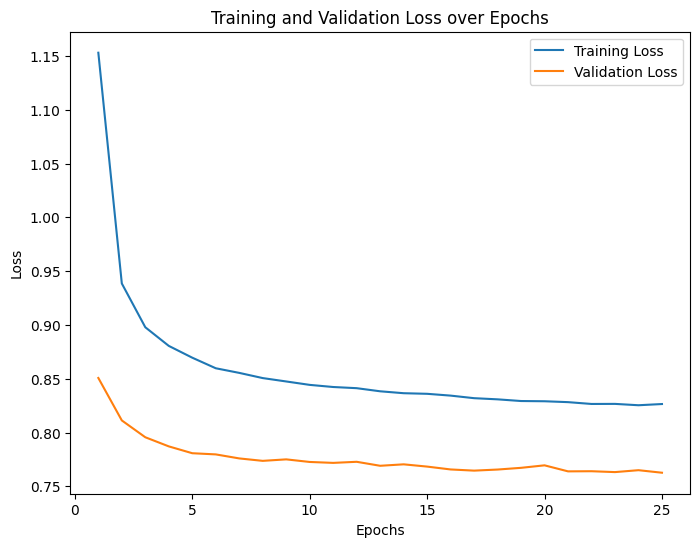

In [1110]:
# After training is complete
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [1111]:
# Prediction function with restriction for `any_specified_feature_true`
def predict_with_restriction(model, X, any_specified_feature_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predictions = torch.max(outputs, 1)
        # Apply restriction: Change "PUSH" predictions if `any_specified_feature_true` is True
        restricted_predictions = []
        for i, pred in enumerate(predictions):
            if any_specified_feature_true[i] and pred == push_label_encoded:
                # Assign a different class (e.g., set to class 0 as a fallback)
                restricted_predictions.append(0)
            else:
                restricted_predictions.append(pred.item())
        return torch.tensor(restricted_predictions)


In [1112]:
# Making predictions with the restriction
any_specified_feature_true = X_test['any_specified_feature_true'].values  # Assuming this is available
X_test_tensor_restricted = torch.tensor(X_test.values, dtype=torch.float32)

restricted_preds = predict_with_restriction(model, X_test_tensor_restricted, any_specified_feature_true)


In [1113]:
# Evaluate the model (you can use metrics like accuracy, F1 score, etc.)
accuracy = (restricted_preds == y_test_tensor).float().mean()
print(f"Accuracy with restriction: {accuracy:.4f}")

Accuracy with restriction: 0.5185


In [1115]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


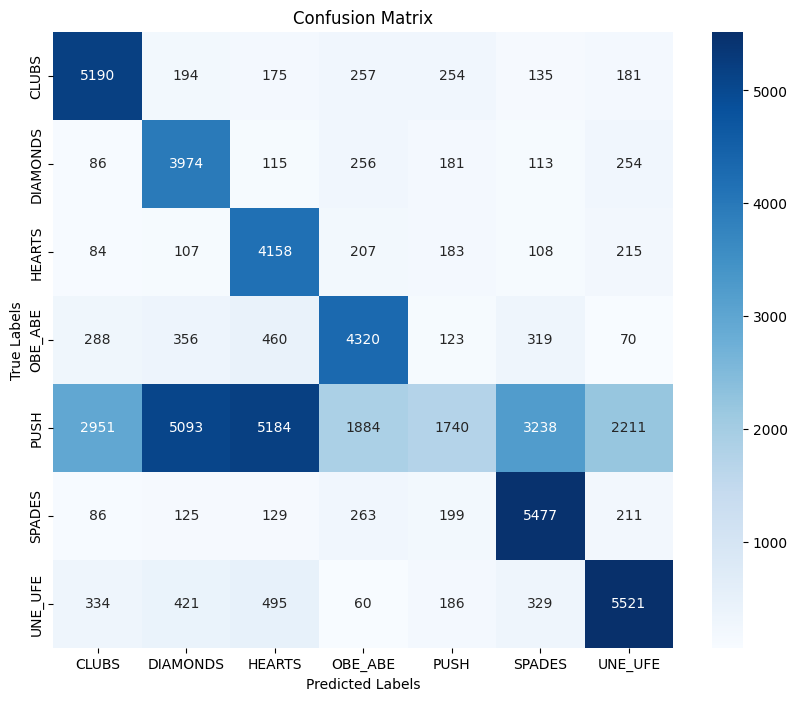

In [1116]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_targets = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_targets.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Get class labels from the label encoder
labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [1098]:
# import joblib
# 
# # Save the trained model
# joblib.dump(mlpc, 'mlp_trump_selector_model.joblib')